# Introduction: Retail Revenue Prediction

In this project, you will predict the revenues of retail stores across all of Norway.

We have been given a large dataset by [Plaace](https://plaace.co/en/), a Norwegian company that matches businesses to retail properties. They have provided us with revenue information for over 20,000 retail stores that will be used to train and evaluate your models. In addition, we have also been provided with a wide selection of supplementary data that can be used to engineer more powerful features, including geo-specific demographic, public transportation information, a hierarchical grouping of the stores, and information about over 28,000 additional stores.

**You may only use the data provided here for your models.** We have made this rule based on experience from previous years to ensure a fair and accurate grading.

This notebook aims to provide you with an introduction to the data. In addition, we give a short tutorial on how to generate and upload a Kaggle submission file. 

## Basics 

We begin by giving a quick overview of the data you've been given, presenting the training and testing set, and introducing the formula we will use to evaluate prediction performance.

### Directory Structure

You are given a collection of comma separated values (csv) files to work with. The two most important files are `stores_train.csv` and `stores_test.csv` which will be covered shortly. The remaining files contain supplementary data that are likely to be useful for crafting a richer feature set. They will be covered later in this notebook.

In [ ]:
!ls ./data | sort

'ls' is not recognized as an internal or external command,
operable program or batch file.


### Train Stores

The `stores_train.csv` dataset is the basis for your training data and contains 12859 rows. 
Each store (row) is associated with the following information:
- `store_id`: unique ID for each store 
- `year`: The year the data is recorded for (should all be 2016)
- `store_name`: Human readable name for each store
- `plaace_hierarchy_id`: Group ID for the store type (see [Place Hierarchy](#Plaace-Hierarchy))
- `sales_channel_name`: Human readable name for the store type 
- `grunnkrets_id`: Geographical ID for the store's location (see [Grunnkrets Data](#Grunnkrets-Data))
- `address`: Street address of the store 
- `lat`: Latitude (north-south) coordinate for the store's location 
- `lon`: Longitude (west-east) coordinate for the store's location 
- `chain_name`: Name of the chain the store belongs to (if available)
- `mall_name`: Name of the mall a store is located in (if available)
- `revenue` (**target**): The store's revenue in 2016. This is what you will be predicting.

In [1]:
import pandas as pd
stores_train = pd.read_csv('data/stores_train.csv')
stores_train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


### Test Stores

The dataset with test stores consists of 8577 rows. Note that it contains the exact same columns as the train set stores, except that the `revenue` column is missing. Your grade in this project will mainly be based on how well you can predict these missing values.

In [2]:
stores_test = pd.read_csv('data/stores_test.csv')
stores_test.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN


### Objective 

Because we consider the revenue a continuous variable, we call this a _regression_ problem. It is common to evaluate regression problems according to some deviation measure of the error (difference) between the predictions and the ground truth values. Typical choices are Mean Squared Error (MSE) and its square root, the Root Mean Squared Error (RMSE).

However, both of these measures are quite sensitive to extreme values and work best if the typical scale of prediction errors are consistent across the dataset. This is not likely to be the case here because the revenue variable varies a lot. This means that a, say 10%, prediction error would matter a lot more if it is for one of the higher-earning stores than for one of the lower-earning ones. Consequently, we will use a variation that takes a log transform of the target variable before computing prediction errors.

**TL;DR**: submissions for this problem will be evaluated according to the `Root Mean Squared Log Error` (RMSLE):

- $\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

In the equation above, $y_i$ corresponds to the ground truth value for datapoint $i$, $\hat{y}_i$ corresponds to the predicted value for datapoint $i$, and $n$ denotes the total number of datapoints (dimensionality of $y$, $\hat{y}$). See the cell below for an implementation.



In [3]:
import numpy as np 

def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))



# Calculate rmsle for a few example predictions
y_true = stores_train.revenue.values
n = len(stores_train)
print('A couple of RMSLE scores computed over the train set')
print(f'Perfect prediction: {rmsle(y_true, y_true):.4f}')
print(f'All zeros prediciton: {rmsle(y_true, np.zeros(n)):.4f}')
print(f'All ones prediction: {rmsle(y_true, np.ones(n)):.4f}')

A couple of RMSLE scores computed over the train set
Perfect prediction: 0.0000
All zeros prediciton: 1.8900
All ones prediction: 1.3606


## Supplementary Data 

The following sections cover the remaining data at your disposal.

### Extra Stores 

The extra stores dataset is a collection of stores for which we had no revenue data. Structurally, it is identical to the test set, but you are naturally not expected to submit any predictions for it. You can, however, use the additional data in your analysis, in unsupervised methods you might employ, or to provide a stronger data basis for missing value imputation.


In [4]:
stores_extra = pd.read_csv('data/stores_extra.csv')
stores_extra.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,911669196-973140302-27020,2016,BURGER KING STRANDGATEN,1.1.1.0,Hamburger restaurants,12010115,STRANDGATEN 5,60.393979,5.323851,BURGER KING,NaN
1,913155726-992998792-5832,2016,BURGER KING JESSHEIM STORSENTER,1.1.1.0,Hamburger restaurants,2350205,STORGATA 6,60.142760,11.171834,BURGER KING,Jessheim Storsenter
2,988252905-981108604-47887,2016,BURGER KING LANGNES,1.1.1.0,Hamburger restaurants,19020419,HULDERVEGEN 6,69.671483,18.920483,BURGER KING,NaN
3,995194546-891354622-45262,2016,BURGER KING MAGNETEN LEVANGER,1.1.1.0,Hamburger restaurants,17190701,NaN,63.732791,11.281785,BURGER KING,Magneten
4,881339692-979954964-3203,2016,BURGER KING ULLEVAAL STADION,1.1.1.0,Hamburger restaurants,3014511,SOGNSVEIEN 75,59.948558,10.732823,BURGER KING,Amfi Ullevaal


### Plaace Hierarchy 

Plaace has provided us with their system for sorting stores into categories in a 4-level hierarchy. The top level of the hierarchy contains the most abstract groupings ("Dining and Experiences", "Retail", and "Services"). As you move further down in the hierarchy, you get more and more specific categories (109 distinct values at level 4).

Each store is associated with a dot-separated `plaace_hierarchy_id`, which gives its group membership at all four levels of the hierarchy. For instance, the id "2.8.11.2" gives groups "Retail" -> "Food and drinks" -> "Alcohol sales" -> "Beer and soda shop". 

In the cell below we use the `pd.DataFrame.merge` method to perform a left join between the train store data and the hierarchy data, using the `plaace_hierarchy_id` as join key. The result is that each train store row gets corresponding place hierarchy information appended to its side (we just visualize the table vertically to make it easier to see all the columns).

In [5]:
# Read plaace_hierarchy data *

stores_train = pd.read_csv('data/stores_train.csv')
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')

# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name_x,grunnkrets_id,address,lat,lon,chain_name,...,revenue,sales_channel_name_y,lv1,lv1_desc,lv2,lv2_desc,lv3,lv3_desc,lv4,lv4_desc
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,...,17.998,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,...,23.828,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,...,16.099,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,...,9.296,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,...,4.528,Hamburger restaurants,1,Dining and Experiences,1.1,Restaurant,1.1.1,Hamburger restaurants,1.1.1.0,Hamburger restaurants
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,915789943-915806929-781991,2016,MEIERIGÅRDEN BRYGGERIUTSALG,2.8.11.2,Beer and soda shop,7010705,THUEGATA 2,59.416276,10.480970,NaN,...,0.088,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
12855,917921733-917982368-868081,2016,GULATING ØLUTSALG CC GJØVIK,2.8.11.2,Beer and soda shop,5020406,NaN,60.799991,10.693635,GULATING GRUPPEN,...,1.816,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
12856,911721961-911764474-496764,2016,GULATING ØLUTSALG STRØMMEN,2.8.11.2,Beer and soda shop,2310803,STØPERIVEIEN 6,59.946562,11.007659,GULATING GRUPPEN,...,38.225,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop
12857,914337046-914343372-721294,2016,DET GODE BRYGG,2.8.11.2,Beer and soda shop,11020113,VÅGSGATA 16,58.850261,5.735674,NaN,...,3.642,Beer and soda shop,2,Retail,2.8,Food and drinks,2.8.11,Alcohol sales,2.8.11.2,Beer and soda shop


### Grunnkrets Data 

Next follows information about different regions in Norway and their demography.
A "[Grunnkrets](https://no.wikipedia.org/wiki/Grunnkrets)" is a type of statistical unit used to describe a small geographic area. The corresponding term in english is "[Basic statistical unit](https://en.wikipedia.org/wiki/Basic_statistical_unit_(Norway))".

We have a total of four extra datasets that provides extra information about the different grunnkrets units in Norway: One describing the grunnkrets itself and three describing its demographics.

All the grunnkrets datasets have a column called `grunnkrets_id`. A corresponding column can be found in the `stores_*` datasets, meaning that you can augment each store with information about the grunnkrets it is located in using similar join logic as the `merge` operation used in the previous section.

Note that we have grunnkrets-related data for both 2015 and 2016, but keep in mind that the revenue predictions you will make are all for 2016. Moreover, the demography data is actually for the district, but has already been mapped to each grunnkrets for us.

#### Geography

The first grunnkrets dataset we will look at describes the geography of each grunnkrets. In addition to the official name of the grunnkrets, we also have the district the grunnkrets is located in, as well as the municipality the district is located in. 

Finally, we also have a polygon describing the geographical area covered by the grunnkrets. If you want to process this data further, we recommend you check out the [geopandas](https://geopandas.org) extension. The area of the polygon (in square kilometers) is already computed and available for you to use.

In [6]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

,grunnkrets_id,year,grunnkrets_name,district_name,municipality_name,geometry,area_km2
0,10010701,2015,Grim-Dueknipen,Grim-Møllevann-Dalane,Kristiansand,MULTIPOLYGON(((7.97199691121304 58.14336769560...,0.768961
1,10010803,2015,Kvadraturen sørøst,Kvadraturen-Eg,Kristiansand,"POLYGON((8.00234207061135 58.1443514886041, 8....",0.361355
2,10020608,2015,Ormestad,Holum,Mandal,"POLYGON((7.48512808482995 58.0374976883392, 7....",0.280188
3,10020901,2015,Tregde,Tregde-Skjernøy,Mandal,MULTIPOLYGON(((7.50996051810658 58.02134863868...,0.156311
4,10030210,2015,Bryneheia,Vanse/Åpta,Farsund,"POLYGON((6.70396719073296 58.0877854965615, 6....",0.791894


#### Age Distribution

Next, we have information about the age distribution in different grunnkrets units. Each column gives the number of people of a given age that lives in the grunnkrets. For instance, the `12` in the first row of column `age_6` means that there are 12 six-year-olds in the corresponding grunnkrets.

In [7]:
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
grunnkrets_ages.head()

,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,16013117,2015,14,14,14,14,13,13,12,11,...,0,0,0,0,0,0,0,0,0,0
1,16013117,2016,10,10,10,10,10,10,9,9,...,0,0,0,0,0,0,0,0,0,0
2,11030206,2015,5,5,5,5,5,4,4,3,...,0,0,0,0,0,0,0,0,0,0
3,16011203,2016,2,2,2,2,2,3,3,3,...,1,1,1,1,1,1,1,0,0,0
4,3011601,2016,7,7,7,7,6,6,5,4,...,1,1,0,0,0,0,0,0,0,0


#### Household Types 

The second demography dataset gives the household composition in each grunnkrets. The different types of households are partitioned into 8 categories. Each column gives the number of households in a given category.

In [8]:
grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_types.head()

,grunnkrets_id,year,couple_children_0_to_5_years,couple_children_18_or_above,couple_children_6_to_17_years,couple_without_children,single_parent_children_0_to_5_years,single_parent_children_18_or_above,single_parent_children_6_to_17_years,singles
0,12010509,2015,0,0,4,0,0,0,0,4
1,14390206,2015,0,7,0,0,0,0,0,3
2,18040514,2015,10,0,0,0,0,0,0,7
3,18040804,2015,0,0,0,0,0,0,0,0
4,18200101,2015,0,6,0,0,0,0,0,4


#### Household Income

The last demography dataset gives median incomes in each grunnkrets. The first income column is `all_households`, which denotes the median income aggregated across all households in the grunnkrets. The last three columns further breaks this figure down for three different types of households.

In [9]:
grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')
grunnkrets_household_income.head()

,grunnkrets_id,year,all_households,singles,couple_without_children,couple_with_children,other_households,single_parent_with_children
0,14200105,2016,551700,270300,0,0,0,0
1,2311202,2015,577700,311800,0,682300,0,0
2,2310501,2015,668800,292500,0,842000,0,0
3,14200401,2016,507000,250700,0,0,0,0
4,14200105,2015,539900,275800,0,710300,0,0


### Busstops

Lastly, we also have information about bus stops all over Norway. Unlike the previous datasets, none of the rows here are directly associated with any of the stores. However, the `geometry` column contains information about the location, which can be compared with the location of stores to generate features.

- `busstop_id`: unique ID for busstop. Not tied to anything else in this dataset 
- `stopplace_type`: what kind of stop it is (e.g. just a curbside stop or a proper bus pocket)
- `importance_level`: how important the stop is (e.g. just a regular stop or a regional hub)
- `side_placement`: position in the road 
- `geometry`: latitude and longitude of location (point geometry)

In [10]:
busstops = pd.read_csv('data/busstops_norway.csv')
busstops.head()

,busstop_id,stopplace_type,importance_level,side_placement,geometry
0,853cb081-cc32-4880-aa3e-26e96870d874,Plattform og lomme,Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(6.54064723379766 61.0618887850553)
1,156b052b-2771-497a-b4f4-97fed59e1aca,"Lomme og skilt, ikke plattform",Mangler viktighetsnivå,LEFT_AND_RIGHT,POINT(5.89980086113255 60.1421872817075)
2,7312a280-e14f-4b09-a421-02e8fe1bc63e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781327278563 59.9299988828761)
3,d9cda2c7-355a-49c1-b56c-a33180d2a82e,NaN,Mangler viktighetsnivå,MIDDLE_LEFT,POINT(10.7781496457324 59.9301044643692)
4,f803bcd3-182d-450b-bbb4-113c6ca885c2,NaN,Mangler viktighetsnivå,MIDDLE_RIGHT,POINT(10.7781676444854 59.9302099995898)


## Getting Started

In this final section, we will go through a sped-up and simplified version of the work we expect you to do; all the way from initial EDA, to "training" a very simple model, and finally using the model to make a submission with test set predictions.

### Analyzing the Data

The first thing you should do is start exploring the data. We often refer to this activity as Exploratory Data Analysis (EDA). In the cell below we make two plots. The first one shows the number of missing values in the `stores_train` dataframe. The second one visualizes the distribution of the target variable (revenue).

In your own work, you should go a lot further than this. You may for instance want to:

- Look for outliers and other parts of the data that should be cleaned up
- Investigate to what degree single variables correlate, both with each other and the target variable
- Visualize different variables spatially, perhaps with maps in the background



Text(0.5, 1.0, 'Distribution of Revenues')

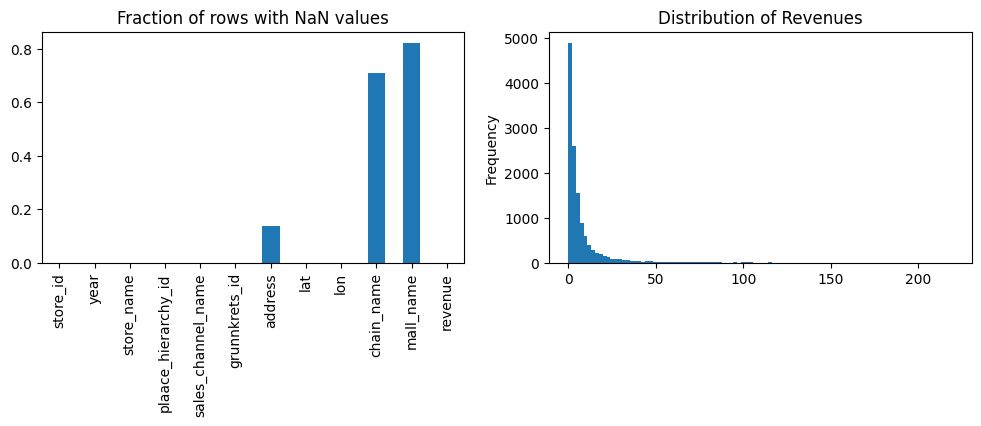

In [11]:
import matplotlib.pyplot as plt 

fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
stores_train.isna().mean().plot.bar(ax=ax1)
ax1.set_title('Fraction of rows with NaN values')
stores_train.revenue.plot.hist(bins=100, ax=ax2)
ax2.set_title('Distribution of Revenues')

In [12]:
stores_train.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528


# Training

In [13]:
def convert_to_category(X):
    for col in X.columns:
        if ( (X[col].dtype != 'int64') and (X[col].dtype != 'float64') and (X[col].dtype != 'bool')):
            X[col] = X[col].astype('category')
            
    return X

def remove_outliers(df, column_names, n):
    for column_name in column_names:
        mean = df[column_name].mean()
        std = df[column_name].std()
        df = df[(df[column_name] > mean - n*std) & (df[column_name] < mean + n*std)]
    return df
    
def log_func(y, shift_var):
    return np.log(y+shift_var)

def exp_func(y, shift_var):
    return np.exp(y)-shift_var

### Imports

In [1091]:
from sklearn import *
import lightgbm as lgbm
import xgboost as xgb
import catboost as cat
from sklearn.model_selection import train_test_split
from sqlalchemy import column

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

### Combining datasets

In [15]:
# import pandas as pd
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(rc={'figure.figsize':(11.7,8.27)})
# corr_matrix = stores_train_copy.corr()
# sns.heatmap(corr_matrix)
# plt.show()

# imputor=IterativeImputer(
#     estimator=BayesianRidge(),
#     imputation_order='ascending', 
#     max_iter=10,
#     tol=1e-3)


In [77]:
oslo_lat = 59.9138688
oslo_lon = 10.7522454
bergen_lat = 60.391263
bergen_lon = 5.322054
trondheim_lat = 63.430515
trondheim_lon = 10.395053
stavanger_lat = 58.969976
stavanger_lon = 5.733107
drammen_lat = 59.742043
drammen_lon = 10.204421


from haversine import haversine, Unit

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# calculate the distance to the cities

def distance_to_city(lat, lon, city_lat, city_lon):
    
    # set 
    distance = haversine((lat, lon), (city_lat, city_lon), unit=Unit.KILOMETERS)
        
    return distance

stores_train['distance_to_oslo'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], oslo_lat, oslo_lon), axis=1)
stores_test['distance_to_oslo'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], oslo_lat, oslo_lon), axis=1)

stores_train[['store_id', 'distance_to_oslo']].to_csv('data/other_data/stores_train_distance_to_oslo.csv', index=False)
stores_test[['store_id', 'distance_to_oslo']].to_csv('data/other_data/stores_test_distance_to_oslo.csv', index=False)

stores_train['distance_to_bergen'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], bergen_lat, bergen_lon), axis=1)
stores_test['distance_to_bergen'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], bergen_lat, bergen_lon), axis=1)

stores_train[['store_id', 'distance_to_bergen']].to_csv('data/other_data/stores_train_distance_to_bergen.csv', index=False)
stores_test[['store_id', 'distance_to_bergen']].to_csv('data/other_data/stores_test_distance_to_bergen.csv', index=False)

# generate distances to Trondheim for stores_train and stores_test

stores_train['distance_to_trondheim'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], trondheim_lat, trondheim_lon), axis=1)
stores_test['distance_to_trondheim'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], trondheim_lat, trondheim_lon), axis=1)

stores_train[['store_id', 'distance_to_trondheim']].to_csv('data/other_data/stores_train_distance_to_trondheim.csv', index=False)
stores_train[['store_id', 'distance_to_trondheim']].to_csv('data/other_data/stores_test_distance_to_trondheim.csv', index=False)

stores_train['distance_to_stavanger'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], stavanger_lat, stavanger_lon), axis=1)
stores_test['distance_to_stavanger'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], stavanger_lat, stavanger_lon), axis=1)

stores_train[['store_id', 'distance_to_stavanger']].to_csv('data/other_data/stores_train_distance_to_stavanger.csv', index=False)
stores_test[['store_id', 'distance_to_stavanger']].to_csv('data/other_data/stores_test_distance_to_stavanger.csv', index=False)

stores_train['distance_to_drammen'] = stores_train.apply(lambda x: distance_to_city(x['lat'], x['lon'], drammen_lat, drammen_lon), axis=1)
stores_test['distance_to_drammen'] = stores_test.apply(lambda x: distance_to_city(x['lat'], x['lon'], drammen_lat, drammen_lon), axis=1)

stores_train[['store_id', 'distance_to_drammen']].to_csv('data/other_data/stores_train_distance_to_drammen.csv', index=False)
stores_test[['store_id', 'distance_to_drammen']].to_csv('data/other_data/stores_test_distance_to_drammen.csv', index = False)


In [1032]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# busstops
stores_train_closest_busstop = pd.read_csv('data/other_data/stores_train_closest_busstop.csv')
stores_test_closest_busstop = pd.read_csv('data/other_data/stores_test_closest_busstop.csv')

stores_train = pd.merge(stores_train, stores_train_closest_busstop, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_busstop, on='store_id', how='left')

stores_train_closest_busstops_250m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_250m.csv')
stores_test_closest_busstops_250m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_250m.csv')

stores_train = pd.merge(stores_train, stores_train_closest_busstops_250m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_busstops_250m, on='store_id', how='left')

stores_train_num_busstops_500m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_500m.csv')
stores_test_num_busstops_500m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_500m, on='store_id', how='left')

stores_train_num_busstops_1000m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_1000m.csv')
stores_test_num_busstops_1000m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_1000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_1000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_1000m, on='store_id', how='left')

stores_train_num_busstops_2500m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_2500m.csv')
stores_test_num_busstops_2500m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_2500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_2500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_2500m, on='store_id', how='left')

stores_train_num_busstops_5000m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_5000m.csv')
stores_test_num_busstops_5000m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_5000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_5000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_5000m, on='store_id', how='left')

stores_train_num_busstops_7500m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_7500m.csv')
stores_test_num_busstops_7500m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_7500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_7500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_7500m, on='store_id', how='left')

stores_train_num_busstops_10000m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_10000m.csv')
stores_test_num_busstops_10000m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_10000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_10000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_10000m, on='store_id', how='left')

stores_train_num_busstops_15000m = pd.read_csv('data/other_data/stores_train_num_closest_busstops_15000m.csv')
stores_test_num_busstops_15000m = pd.read_csv('data/other_data/stores_test_num_closest_busstops_15000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_busstops_15000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_busstops_15000m, on='store_id', how='left')


# stores

# closest store
stores_train_closest_store_lv1 = pd.read_csv('data/other_data/stores_train_closest_store_lv1.csv')
stores_test_closest_store_lv1 = pd.read_csv('data/other_data/stores_test_closest_store_lv1.csv')

stores_train = pd.merge(stores_train, stores_train_closest_store_lv1, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_store_lv1, on='store_id', how='left')

stores_train_closest_store_lv2 = pd.read_csv('data/other_data/stores_train_closest_store_lv2.csv')
stores_test_closest_store_lv2 = pd.read_csv('data/other_data/stores_test_closest_store_lv2.csv')

stores_train = pd.merge(stores_train, stores_train_closest_store_lv2, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_store_lv2, on='store_id', how='left')

stores_train_closest_store_lv3 = pd.read_csv('data/other_data/stores_train_closest_store_lv3.csv')
stores_test_closest_store_lv3 = pd.read_csv('data/other_data/stores_test_closest_store_lv3.csv')

stores_train = pd.merge(stores_train, stores_train_closest_store_lv3, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_store_lv3, on='store_id', how='left')

stores_train_closest_store_lv4 = pd.read_csv('data/other_data/stores_train_closest_store_lv4.csv')
stores_test_closest_store_lv4 = pd.read_csv('data/other_data/stores_test_closest_store_lv4.csv')

stores_train = pd.merge(stores_train, stores_train_closest_store_lv4, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_closest_store_lv4, on='store_id', how='left')

# num closest stores

#lv1

stores_train_num_closest_stores_lv1_250m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_250m.csv')
stores_test_num_closest_stores_lv1_250m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_250m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_250m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_250m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_500m.csv')
stores_test_num_closest_stores_lv1_500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_500m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_1000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_1000m.csv')
stores_test_num_closest_stores_lv1_1000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_1000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_1000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_1000m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_2500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_2500m.csv')
stores_test_num_closest_stores_lv1_2500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_2500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_2500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_2500m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_5000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_5000m.csv')
stores_test_num_closest_stores_lv1_5000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_5000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_5000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_5000m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_7500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_7500m.csv')
stores_test_num_closest_stores_lv1_7500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_7500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_7500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_7500m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_10000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_10000m.csv')
stores_test_num_closest_stores_lv1_10000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_10000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_10000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_10000m, on='store_id', how='left')

stores_train_num_closest_stores_lv1_15000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv1_15000m.csv')
stores_test_num_closest_stores_lv1_15000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv1_15000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv1_15000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv1_15000m, on='store_id', how='left')


# lv2
stores_train_num_closest_stores_lv2_250m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_250m.csv')
stores_test_num_closest_stores_lv2_250m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_250m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_250m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_250m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_500m.csv')
stores_test_num_closest_stores_lv2_500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_500m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_1000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_1000m.csv')
stores_test_num_closest_stores_lv2_1000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_1000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_1000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_1000m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_2500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_2500m.csv')
stores_test_num_closest_stores_lv2_2500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_2500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_2500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_2500m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_5000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_5000m.csv')
stores_test_num_closest_stores_lv2_5000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_5000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_5000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_5000m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_7500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_7500m.csv')
stores_test_num_closest_stores_lv2_7500m= pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_7500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_7500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_7500m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_10000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_10000m.csv')
stores_test_num_closest_stores_lv2_10000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_10000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_10000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_10000m, on='store_id', how='left')

stores_train_num_closest_stores_lv2_15000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv2_15000m.csv')
stores_test_num_closest_stores_lv2_15000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv2_15000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv2_15000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv2_15000m, on='store_id', how='left')

# lv3

stores_train_num_closest_stores_lv3_250m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_250m.csv')
stores_test_num_closest_stores_lv3_250m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_250m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_250m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_250m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_500m.csv')
stores_test_num_closest_stores_lv3_500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_500m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_1000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_1000m.csv')
stores_test_num_closest_stores_lv3_1000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_1000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_1000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_1000m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_2500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_2500m.csv')
stores_test_num_closest_stores_lv3_2500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_2500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_2500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_2500m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_5000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_5000m.csv')
stores_test_num_closest_stores_lv3_5000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_5000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_5000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_5000m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_7500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_7500m.csv')
stores_test_num_closest_stores_lv3_7500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_7500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_7500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_7500m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_10000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_10000m.csv')
stores_test_num_closest_stores_lv3_10000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_10000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_10000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_10000m, on='store_id', how='left')

stores_train_num_closest_stores_lv3_15000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv3_15000m.csv')
stores_test_num_closest_stores_lv3_15000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv3_15000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv3_15000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv3_15000m, on='store_id', how='left')


# lv4

stores_train_num_closest_stores_lv4_250m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_250m.csv')
stores_test_num_closest_stores_lv4_250m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_250m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_250m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_250m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_500m.csv')
stores_test_num_closest_stores_lv4_500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_500m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_1000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_1000m.csv')
stores_test_num_closest_stores_lv4_1000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_1000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_1000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_1000m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_2500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_2500m.csv')
stores_test_num_closest_stores_lv4_2500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_2500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_2500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_2500m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_5000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_5000m.csv')
stores_test_num_closest_stores_lv4_5000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_5000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_5000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_5000m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_7500m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_7500m.csv')
stores_test_num_closest_stores_lv4_7500m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_7500m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_7500m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_7500m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_10000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_10000m.csv')
stores_test_num_closest_stores_lv4_10000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_10000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_10000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_10000m, on='store_id', how='left')

stores_train_num_closest_stores_lv4_15000m = pd.read_csv('data/other_data/stores_train_num_closest_stores_lv4_15000m.csv')
stores_test_num_closest_stores_lv4_15000m = pd.read_csv('data/other_data/stores_test_num_closest_stores_lv4_15000m.csv')

stores_train = pd.merge(stores_train, stores_train_num_closest_stores_lv4_15000m, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_num_closest_stores_lv4_15000m, on='store_id', how='left')

stores_train_distance_to_oslo = pd.read_csv('data/other_data/stores_train_distance_to_oslo.csv')
stores_test_distance_to_oslo = pd.read_csv('data/other_data/stores_test_distance_to_oslo.csv')

stores_train = pd.merge(stores_train, stores_train_distance_to_oslo, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_distance_to_oslo, on='store_id', how='left')

stores_train_distance_to_bergen = pd.read_csv('data/other_data/stores_train_distance_to_bergen.csv')
stores_test_distance_to_bergen = pd.read_csv('data/other_data/stores_test_distance_to_bergen.csv')

stores_train = pd.merge(stores_train, stores_train_distance_to_bergen, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_distance_to_bergen, on='store_id', how='left')

stores_train_distance_to_trondheim = pd.read_csv('data/other_data/stores_train_distance_to_trondheim.csv')
stores_test_distance_to_trondheim = pd.read_csv('data/other_data/stores_test_distance_to_trondheim.csv')

stores_train = pd.merge(stores_train, stores_train_distance_to_trondheim, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_distance_to_trondheim, on='store_id', how='left')

stores_train_distance_to_stavanger = pd.read_csv('data/other_data/stores_train_distance_to_stavanger.csv')
stores_test_distance_to_stavanger = pd.read_csv('data/other_data/stores_test_distance_to_stavanger.csv')

stores_train = pd.merge(stores_train, stores_train_distance_to_stavanger, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_distance_to_stavanger, on='store_id', how='left')

stores_train_distance_to_drammen = pd.read_csv('data/other_data/stores_train_distance_to_drammen.csv')
stores_test_distance_to_drammen = pd.read_csv('data/other_data/stores_test_distance_to_drammen.csv')

stores_train = pd.merge(stores_train, stores_train_distance_to_drammen, on='store_id', how='left')
stores_test = pd.merge(stores_test, stores_test_distance_to_drammen, on='store_id', how='left')

stores_train.to_csv('data/stores_train_with_extra_features.csv', index=False)
stores_test.to_csv('data/stores_test_with_extra_features.csv', index=False)

In [1427]:
stores_train = pd.read_csv('data/stores_train_with_extra_features.csv')
stores_test = pd.read_csv('data/stores_test_with_extra_features.csv')


stores_train_copy= stores_train.copy()

plaace_hierarchy_copy = plaace_hierarchy.copy()
plaace_hierarchy_copy.drop(columns='sales_channel_name', inplace=True)
plaace_hierarchy_copy['lv1'] = plaace_hierarchy_copy['lv1'].astype('category')
plaace_hierarchy_copy['lv2'] = plaace_hierarchy_copy['lv2'].astype('category')


grunnkrets_copy = grunnkrets.copy()
grunnkrets_copy.rename(columns={'year': 'year_1'}, inplace=True)

grunnkrets_ages_copy = grunnkrets_ages.copy()
grunnkrets_ages_copy.rename(columns={'year': 'year_2'}, inplace=True)

grunnkrets_household_types_copy = grunnkrets_household_types.copy()
grunnkrets_household_types_copy.rename(columns={'year': 'year_3'}, inplace=True)
grunnkrets_household_types_copy[grunnkrets_household_types_copy.columns[2:]] = grunnkrets_household_types_copy[grunnkrets_household_types_copy.columns[2:]].astype('int64')

grunnkrets_household_income_copy = grunnkrets_household_income.copy()
grunnkrets_household_income_copy.rename(columns={'year': 'year_4', 'singles': 'singles_income','couple_without_children':'couple_without_children_income'}, inplace=True)
grunnkrets_household_income_copy.rename(columns={'singles': 'singles_income', }, inplace=True)

#set the values that are 0 to the lowest value in the column
# for column in grunnkrets_household_income_copy.columns[2:]:
#     grunnkrets_household_income_copy[column] = grunnkrets_household_income_copy[column].apply(lambda x: grunnkrets_household_income_copy[column].min() if x == 0 else x)
    

df = stores_train_copy

df = pd.merge(df, plaace_hierarchy_copy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income_copy, on='grunnkrets_id', how='left')

df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

columns_to_drop = ['revenue',
                  'store_id',
                  'plaace_hierarchy_id',
                  'grunnkrets_id',
                  'year',
                   'address',
                  'store_name',
                  
                  'year_1',
                  'geometry',
                  
                  #'area_km2',
               
                  'grunnkrets_name',
                  'district_name',
             
                  'municipality_name',
                  
                  
                  'year_2',
                  'year_3',
                  'year_4',
                 
                
                  'sales_channel_name',
                   #'mall_name',
                  #'chain_name',
                  
                  
                  
                     'lv1',
                  'lv2',
                  'lv3',
                  'lv4',
                  
                  # 'lv1_desc',
                  # 'lv2_desc',
                  # 'lv3_desc',
                  # 'lv4_desc'
                
#                 'closest_busstop',
                  
#     'num_closest_busstops_250m',
#    'num_closest_busstops_500m',

#        'num_closest_busstops_1000m', 'num_closest_busstops_2500m',
#        'num_closest_busstops_5000m', 
#        'num_closest_busstops',
#        'num_closest_busstops_10000m', 'num_closest_busstops_15000m',
       
#        'closest_store_lv1', 'closest_store_lv2',
#        'closest_store_lv3', 'closest_store_lv4', 
       
#        'num_closest_stores_lv1_250m',   
#    'num_closest_stores_lv1_500m', 
   
#    'num_closest_stores_lv1_1000m',
    
#     'num_closest_stores_lv1_2500m',
#        'num_closest_stores_lv1_5000m', 'num_closest_stores_lv1',
#        'num_closest_stores_lv1_10000m', 
# 'num_closest_stores_lv1_15000m',
       
#        'num_closest_stores_lv2_250m', 
   
   
#    'num_closest_stores_lv2_500m',
   
#     'num_closest_stores_lv2_1000m', 
    
#     'num_closest_stores_lv2_2500m',
#        'num_closest_stores_lv2_5000m',
#        'num_closest_stores_lv2',
#        'num_closest_stores_lv2_10000m', 'num_closest_stores_lv2_15000m',
       
#         'num_closest_stores_lv3_250m', 
   
   
#    'num_closest_stores_lv3_500m',
   
#        'num_closest_stores_lv3_1000m', 'num_closest_stores_lv3_2500m',
#        'num_closest_stores_lv3_5000m', 
#        'num_closest_stores_lv3',
#        'num_closest_stores_lv3_10000m', 'num_closest_stores_lv3_15000m',
       
#         'num_closest_stores_lv4_250m', 
   
#    'num_closest_stores_lv4_500m',
   
#        'num_closest_stores_lv4_1000m', 'num_closest_stores_lv4_2500m',
#        'num_closest_stores_lv4_5000m', 
#        'num_closest_stores_lv4',
#        'num_closest_stores_lv4_10000m', 'num_closest_stores_lv4_15000m',
                  # 'distance_to_oslo',
                  # 'distance_to_bergen',
                  # 'distance_to_trondheim',
                  # 'distance_to_stavanger',
                  # 'distance_to_drammen',
                  
                  ]


# fill in missing values of float columns with mean


X = df.drop(columns=columns_to_drop)
X = convert_to_category(X)

y = df.revenue
y = np.log1p(y)




categorical_features = X.select_dtypes(include=['category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns



# One hot encoding
        
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
one_hot_encoder = full_pipeline.fit(X)
X_encoded_one_hot = one_hot_encoder.transform(X)




# Target encoding

#X_total = pd.concat([X, y], axis=1)

# X_encoded_target = X_total.copy()


# X_encoded_target = X_encoded_target[np.abs(X_encoded_target.revenue - X_encoded_target.revenue.mean()) <= (3 * X_encoded_target.revenue.std())]

# all_means = {}

# for column in categorical_features:
   
#    column_means = X_encoded_target.groupby(column)[column,'revenue'].mean().to_dict()['revenue']
   
#    X_encoded_target[column] = X_encoded_target.groupby(column)['revenue'].transform('mean')
   
#    all_means[column] = column_means

# y_target = X_encoded_target.revenue
    
# X_encoded_target.drop(columns=['revenue'], inplace=True)



### Models

In [1520]:
test_size = 0.2
random_state = 12

# X_selected = X_encoded_target.copy()
# y_selected = y_target.copy()

X_selected = X_encoded_one_hot.copy()
y_selected = y.copy()

# LGBM

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

params_lgbm = {'n_estimators': 5000,
'reg_alpha': 30,
#'reg_lambda': 30,
#  'colsample_bytree': 0.792921170856396,
#  'subsample': 0.5806730887895548,
'learning_rate': 0.01,
#  'max_depth': 49,
'num_leaves': 10,
#  'min_child_samples': 136
'metric': 'rmse',
 
}

params_lgbm_one_hot={}

params_lgbm_target={}


lgbm_model = lgbm.LGBMRegressor(
                             **params_lgbm
                            #    **params_lgbm_one_hot
                            #    **params_lgbm_target
                               )

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
        
    lgbm_model.fit(X_train, y_train)

    y_train_pred_lgbm = lgbm_model.predict(X_train)
    y_val_pred_lgbm = lgbm_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_lgbm = np.expm1(y_train_pred_lgbm)
    y_val_pred_lgbm = np.expm1(y_val_pred_lgbm)
    y_train_pred_lgbm[y_train_pred_lgbm < 0] = 0
    y_val_pred_lgbm[y_val_pred_lgbm < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_lgbm)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_lgbm)


print(f'Train set LGBM RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set LGBM RMSLE: {kf_val_scores.mean():.4f}')

In [1470]:
# XGBoost

X_selected = X_encoded_one_hot.copy()
y_selected = y.copy()


X_train, X_val, y_train, y_val = train_test_split(X_selected, y_selected, test_size=test_size, random_state=random_state)

params_xgb_one_hot = {'max_depth': 3,
 'learning_rate': 0.050728814043752145,
 'n_estimators': 2040,
 'min_child_weight': 5,
 'gamma': 5.129890892047405e-07,
 'subsample': 0.8526404813622762,
 'colsample_bytree': 0.2886407409856821,
 'reg_alpha': 0.053174255947560346,
 'reg_lambda': 4.7108630820633026e-07
 
 }

params_xgb_target = {}

xgboost_model = xgb.XGBRegressor(
                                 #**params_xgb_one_hot
                                 #**params_xgb_target
                                 )

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    # X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[test_index]
    X_train, X_val = X_selected[train_index], X_selected[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    
    xgboost_model.fit(X_train, y_train)

    y_train_pred_xgb = xgboost_model.predict(X_train)
    y_val_pred_xgb = xgboost_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_xgb = np.expm1(y_train_pred_xgb)
    y_val_pred_xgb = np.expm1(y_val_pred_xgb)
    y_train_pred_xgb[y_train_pred_xgb < 0] = 0
    y_val_pred_xgb[y_val_pred_xgb < 0] = 0
    
    kf_train_scores[idx] = rmsle(y_train, y_train_pred_xgb)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_xgb)


print(f'Train set XGBoost RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set XGBoost RMSLE: {kf_val_scores.mean():.4f}')

Train set XGBoost RMSLE: 0.5291
Validation set XGBoost RMSLE: 0.7471


In [1471]:
# CatBoost
X_selected = X_encoded_one_hot.copy()
y_selected = y.copy()


params_cat_one_hot = {'learning_rate': 0.1,
 'depth': 4,
 'l2_leaf_reg': 2.5,
 'min_child_samples': 4,
 'iterations': 500}


params_cat_target={}


cat_boost_model = cat.CatBoostRegressor(
                                        #**params_cat_one_hot
                                        # **params_cat_target
                                        )

kf = KFold(n_splits=5, shuffle=True, random_state=12)

kf_train_scores = np.empty(5)
kf_val_scores = np.empty(5)


for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    # X_train, X_val = X_selected.iloc[train_index], X_selected.iloc[test_index]
    X_train, X_val = X_selected[train_index], X_selected[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    
    cat_boost_model.fit(X_train, y_train)

    y_train_pred_cat = cat_boost_model.predict(X_train)
    y_val_pred_cat = cat_boost_model.predict(X_val)

    y_train = np.expm1(y_train)
    y_val = np.expm1(y_val)
    y_train_pred_cat = np.expm1(y_train_pred_cat)
    y_val_pred_cat = np.expm1(y_val_pred_cat)
    y_train_pred_cat[y_train_pred_cat < 0] = 0
    y_val_pred_cat[y_val_pred_cat < 0] = 0

    kf_train_scores[idx] = rmsle(y_train, y_train_pred_cat)
    kf_val_scores[idx] = rmsle(y_val, y_val_pred_cat)
    
print(f'Train set CatBoost RMSLE: {kf_train_scores.mean():.4f}')
print(f'Validation set CatBoost RMSLE: {kf_val_scores.mean():.4f}')

Learning rate set to 0.059173
0:	learn: 1.0030634	total: 11.5ms	remaining: 11.5s
1:	learn: 0.9843112	total: 23.4ms	remaining: 11.7s
2:	learn: 0.9669279	total: 32.9ms	remaining: 10.9s
3:	learn: 0.9507383	total: 43.2ms	remaining: 10.8s
4:	learn: 0.9368974	total: 54ms	remaining: 10.7s
5:	learn: 0.9237745	total: 64.3ms	remaining: 10.7s
6:	learn: 0.9106774	total: 74.8ms	remaining: 10.6s
7:	learn: 0.8993099	total: 84.8ms	remaining: 10.5s
8:	learn: 0.8887911	total: 95.2ms	remaining: 10.5s
9:	learn: 0.8796532	total: 105ms	remaining: 10.4s
10:	learn: 0.8712533	total: 116ms	remaining: 10.4s
11:	learn: 0.8637832	total: 126ms	remaining: 10.4s
12:	learn: 0.8571010	total: 136ms	remaining: 10.4s
13:	learn: 0.8498927	total: 147ms	remaining: 10.3s
14:	learn: 0.8444951	total: 157ms	remaining: 10.3s
15:	learn: 0.8391549	total: 168ms	remaining: 10.3s
16:	learn: 0.8344597	total: 179ms	remaining: 10.3s
17:	learn: 0.8309441	total: 189ms	remaining: 10.3s
18:	learn: 0.8273328	total: 199ms	remaining: 10.3s
19:	

In [1502]:
lgbm_model.fit(X, y)
xgboost_model.fit(X_selected, y_selected)
cat_boost_model.fit(X_selected, y_selected)

Learning rate set to 0.061296
0:	learn: 1.0024762	total: 12.3ms	remaining: 12.3s
1:	learn: 0.9831702	total: 25.2ms	remaining: 12.6s
2:	learn: 0.9648636	total: 37.4ms	remaining: 12.4s
3:	learn: 0.9470351	total: 49ms	remaining: 12.2s
4:	learn: 0.9324402	total: 61.5ms	remaining: 12.2s
5:	learn: 0.9179002	total: 74ms	remaining: 12.3s
6:	learn: 0.9051754	total: 85.5ms	remaining: 12.1s
7:	learn: 0.8936187	total: 96.6ms	remaining: 12s
8:	learn: 0.8833588	total: 108ms	remaining: 11.9s
9:	learn: 0.8752648	total: 120ms	remaining: 11.9s
10:	learn: 0.8675294	total: 132ms	remaining: 11.8s
11:	learn: 0.8604084	total: 144ms	remaining: 11.8s
12:	learn: 0.8537894	total: 155ms	remaining: 11.8s
13:	learn: 0.8467584	total: 166ms	remaining: 11.7s
14:	learn: 0.8411492	total: 177ms	remaining: 11.7s
15:	learn: 0.8354503	total: 188ms	remaining: 11.6s
16:	learn: 0.8311570	total: 200ms	remaining: 11.6s
17:	learn: 0.8269771	total: 212ms	remaining: 11.6s
18:	learn: 0.8226855	total: 223ms	remaining: 11.5s
19:	learn

### Creating a Submission

Finally, we used the "trained" model to make predictions on the test set and turn it into a submission for kaggle. The format for submissions is a simple csv file with two columns; one for the store id and one for the predicted revenue.
An example of what the start of the file should look like can be seen below:


```
id,predicted
914206820-914239427-717245,181.66162783399506
916789157-916823770-824309,206.81469433388355
913341082-977479363-2948,83.49386666841214
...
```

Keep in mind the following when generating predictions:
- Make sure that the csv  <id, predicted> columns.
- Make sure that the ID values correctly correspond to each prediction. 
- Make sure there are no negative, nan, or other non-numeric values in your submission 


In [1503]:
# Predict on the test set

colums_to_drop = columns_to_drop[1:]
stores_test_copy = stores_test.copy()

df = stores_test_copy

df = pd.merge(df, plaace_hierarchy_copy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income_copy, on='grunnkrets_id', how='left')

df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)

X_test = df.drop(columns = colums_to_drop)
X_test = convert_to_category(X_test)


X_test_encoded_one_hot = one_hot_encoder.transform(X_test)


# X_test_encoded_target = X_test.copy()

# for column in categorical_features:
#     X_test_encoded_target[column] = X_test_encoded_target[column].map(all_means[column])
#     # convert to float
#     X_test_encoded_target[column] = X_test_encoded_target[column].astype(float)

    


y_test_pred = 0
n = 0

X_test_selected = X_test_encoded_one_hot.copy()


y_test_pred_lgbm = lgbm_model.predict(X_test)
y_test_pred_lgbm = np.expm1(y_test_pred_lgbm)
y_test_pred_lgbm = np.where(y_test_pred_lgbm < 0, 0, y_test_pred_lgbm)
y_test_pred += y_test_pred_lgbm
n+=1


y_test_pred_xgb = xgboost_model.predict(X_test_selected)
y_test_pred_xgb = np.expm1(y_test_pred_xgb)
y_test_pred_xgb = np.where(y_test_pred_xgb < 0, 0, y_test_pred_xgb)
# y_test_pred += y_test_pred_xgb
# n+=1


y_test_pred_cat = cat_boost_model.predict(X_test_selected)
y_test_pred_cat = np.expm1(y_test_pred_cat)
y_test_pred_cat = np.where(y_test_pred_cat < 0, 0, y_test_pred_cat)
# y_test_pred += y_test_pred_cat
# n+=1


y_test_pred = y_test_pred/n

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = stores_test['store_id']
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submissions/sample_submission.csv', index=False)
submission


,id,predicted
0,914206820-914239427-717245,5.698689
1,916789157-916823770-824309,7.667977
2,913341082-977479363-2948,3.543397
3,889682582-889697172-28720,8.285566
4,997991699-998006945-417222,4.498862
...,...,...
8572,917323003-917383529-844309,2.328819
8573,917353379-917411824-845904,3.839687
8574,917072302-917089248-833647,3.346594
8575,916960557-916993161-829908,2.614346


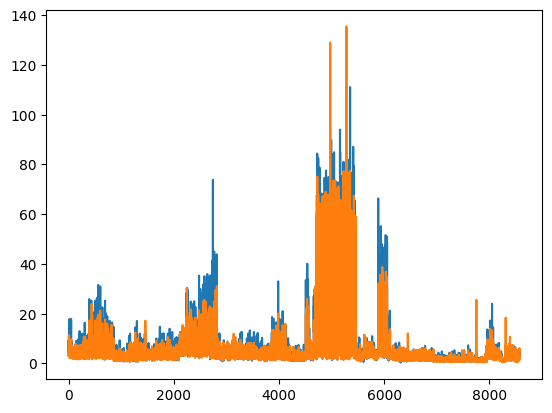

In [1478]:

import matplotlib.pyplot as plt

plt.plot(y_test_pred_lgbm)
#plt.plot(y_test_pred_xgb)
plt.plot(y_test_pred_cat)
#plt.plot(y_test_pred)

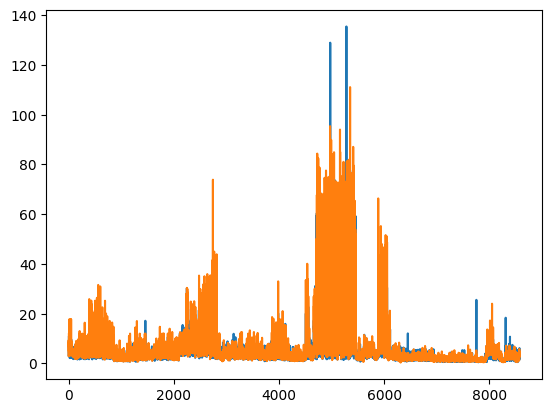

In [1479]:
#plt.plot(y_test_pred_xgb)
plt.plot(y_test_pred_cat)
plt.plot(y_test_pred_lgbm)


In [1289]:
# calculate the mean 

rmsle_lgbm_xgb = rmsle(y_test_pred_lgbm, y_test_pred_xgb)
rmsle_lgbm_cat = rmsle(y_test_pred_lgbm, y_test_pred_cat)
rmsle_xgb_cat = rmsle(y_test_pred_xgb, y_test_pred_cat)

print(f'RMSLE lgbm xgb: {rmsle_lgbm_xgb :.4f}')
print(f'RMSLE lgbm cat: {rmsle_lgbm_cat :.4f}')
print(f'RMSLE xgb cat: {rmsle_xgb_cat :.4f}')
print(f'Average RMSLE: {np.mean([rmsle_lgbm_xgb, rmsle_lgbm_cat, rmsle_xgb_cat]) :.4f}')

RMSLE lgbm xgb: 0.3618
RMSLE lgbm cat: 0.2621
RMSLE xgb cat: 0.3245
Average RMSLE: 0.3161


### Uploading to Kaggle


Once a submission csv has been created, it can be uploaded to Kaggle. If you haven't already, you can enroll in the Kaggle competition by following [this special link](https://www.kaggle.com/t/3affe88e40c44dde87d1ff836ded9e92) along with the rest of your teammates.

You can upload submissions manually through the competition web page [as explained here](https://www.kaggle.com/docs/competitions#submitting-predictions). 


Alternatively, you can use the Kaggle API ([see here for installation instructions](https://github.com/Kaggle/kaggle-api)) and do it from the terminal with the following command template:

```bash
kaggle competitions submit tdt4173-2022-project2 -f <filepath> -m "<message>"
```

Where `<filepath>` in this case would be `./sample_submission.csv` and `<message>` is your own comment for the submission.

Note that your prediction performance on the test set is broken down into two parts; a `public` and a `private` one. When you upload a submission, you will immediately be able to see your public score, which is computed over a subset of the test set rows. The private score is calculated over the remaining datapoints and will not be visible until the end of the project, but is what ultimately determines the score-based part of your grade.

There is a limit to the maximum number of submissions you can submit on Kaggle each day (5 at the time of writing). Keep this in mind when submitting, but don't hesitate to use all your submissions every day; they will provide you with feedback and renew each new day.

## Next Steps

- Plot, summarize, and get familiar with the dataset. If you have any questions, don't hesitate to ask the course staff. If we don't know the answer, we can try to reach out to the data scientists at Plaace. Don't be surprised if you find the dataset to be a bit noisy. Like most real-world datasets, it is aggregated from many imperfect (and sometimes contradictory) sources.

- Try to make some very simple models. How well does a simple mean estimate do? Can you improve on the mean by including information from a single feature? Do any variables have simple, linear relationships with the revenue? Can you make the relationships (more) linear? In addition to getting you more familiar with the dataset, making simple models establishes baselines that can be used to reason about more complex approaches later.

- Try to apply different machine learning algorithms. The [Scikit-Learn](https://scikit-learn.org/stable/) package is a good starting point that contains stable implementations of many popular algorithms. In addition, we recommend you look into gradient boosting algorithms such as [xgboost](https://xgboost.readthedocs.io/en/stable/), [catboost](https://catboost.ai/), and [lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/). Keep in mind that as you start applying more complex learning algorithms, you start running the risk of overfitting and may need to use validation data to tune hyperparameters. 

- As you start to get several decent models, start thinking about ensembling them. This will typically allow you to squeeze out a bit more performance. In general, an ensemble works better if the individual member models make uncorrelated errors. Different algorithms, features, and even hyperparameters tend to lead to uncorrelated errors.

- Feel free to draw inspiration from others online, just adapt the solutions you find to the problem at hand and make sure you understand it. The Kaggle platform is a goldmine in this regard and contains tutorial notebooks on everything from [basic data science](https://www.kaggle.com/code/kanncaa1/data-sciencetutorial-for-beginners), [general machine learning](https://www.kaggle.com/code/kanncaa1/machine-learning-tutorial-for-beginners/notebook), and [boosting](https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression/notebook). 